<a href="https://colab.research.google.com/github/ArfianAl/Bullience-ML-Bangkit-Team/blob/main/Model_Violence_Revisi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
import tensorflow as tf
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '--'
import re
import string
import nltk
nltk.download('stopwords')
sns.despine()
plt.style.use("fivethirtyeight")
sns.set_style("darkgrid")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<Figure size 640x480 with 0 Axes>

In [2]:
pip install openpyxl

In [4]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
dv = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Bangkit/DATASETS GABUNGAN BULLIENCE - Dataset Violence.csv")
dv

,Teks,Label
0,selamat sore saya adalah ibu dari satu anak sa...,Violence
1,mohon bantu pak saya sedang hamil pak diluar n...,Non-Violence
2,saya seorang anak perempuan yang bersuami teta...,Violence
3,jika anak perempuan tidak di beri nafkah orang...,Non-Violence
4,pak saya status pernikahan sudah setahun pisah...,Violence
...,...,...
201,Kami bersama-sama membangun program mentorship...,Non-Violence
202,"Dalam menjalani kehidupan sehari-hari, kami be...",Non-Violence
203,Melibatkan generasi muda dalam kegiatan positi...,Non-Violence
204,Kami aktif dalam kampanye keamanan jalan raya ...,Non-Violence


In [6]:
dv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Teks    206 non-null    object
 1   Label   206 non-null    object
dtypes: object(2)
memory usage: 3.3+ KB


In [7]:
# Checking for null values
dv.isnull().values.any()

False

In [8]:
# Melihat jumlah masing-masing tipe
dv['Label'].value_counts()

Violence        103
Non-Violence    103
Name: Label, dtype: int64

Counter({'Violence': 103, 'Non-Violence': 103})


<Axes: xlabel='Label', ylabel='count'>

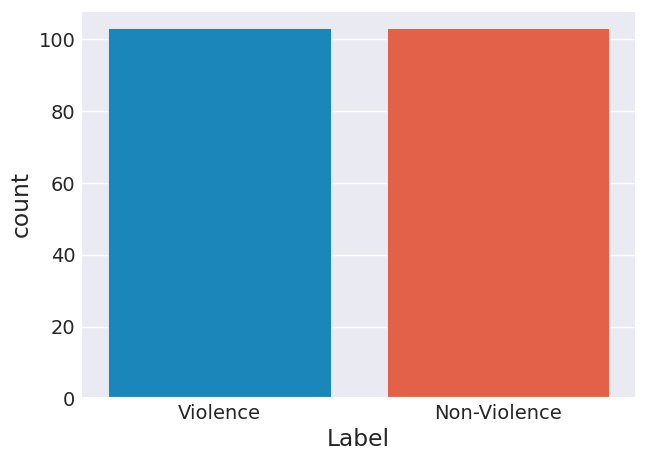

In [9]:
# Distribusi Target
x = dv.Teks
y = dv.Label

from collections import Counter

print(Counter(y))
sns.countplot(x=y)

count    103.000000
mean      22.126214
std       11.981751
min        6.000000
25%       15.000000
50%       21.000000
75%       25.000000
max       94.000000
Name: Length, dtype: float64

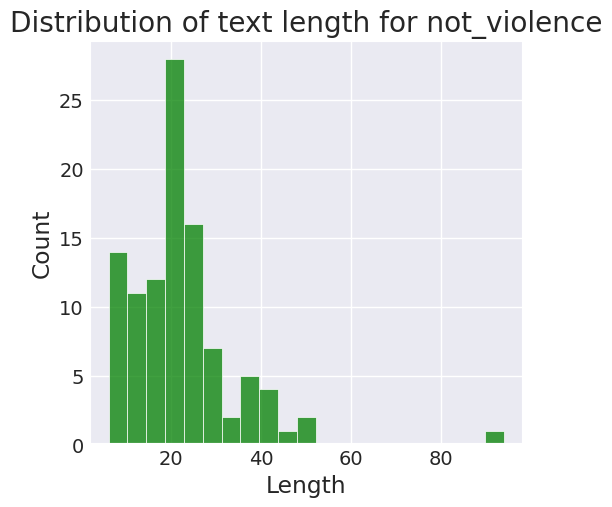

In [10]:
# Melihat statistical description serta histogram panjang teks Non-B
dv["Length"] = dv.Teks.str.split().apply(len)
plt.figure(figsize=(5,5))
sns.histplot(dv[dv["Label"]=="Non-Violence"]['Length'],color="g")
plt.title("Distribution of text length for not_violence")
display(dv.Length[dv["Label"]=="Non-Violence"].describe())

count    103.000000
mean      17.631068
std       13.782619
min        4.000000
25%        8.500000
50%       14.000000
75%       20.000000
max       77.000000
Name: Length, dtype: float64

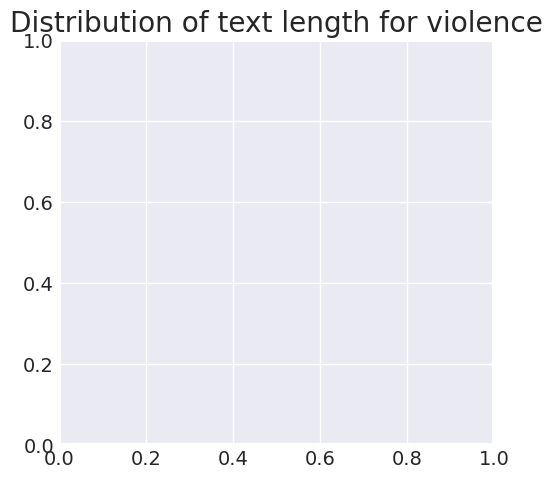

In [11]:
# Melihat statistical description serta histogram panjang teks B
dv["Length"] = dv.Teks.str.split().apply(len)
plt.figure(figsize=(5,5))
sns.histplot(dv[dv["Label"]=="violence"]['Length'],color="r")
plt.title("Distribution of text length for violence")
display(dv.Length[dv["Label"]=="Violence"].describe())

In [12]:
# variabel untuk kolom teks
texts = dv.Teks
print(texts.head())

0    selamat sore saya adalah ibu dari satu anak sa...
1    mohon bantu pak saya sedang hamil pak diluar n...
2    saya seorang anak perempuan yang bersuami teta...
3    jika anak perempuan tidak di beri nafkah orang...
4    pak saya status pernikahan sudah setahun pisah...
Name: Teks, dtype: object


In [13]:
# Case Folding
# gunakan fungsi series.str.lower() pada Pandas
texts = texts.str.lower()

print(texts.head())

0    selamat sore saya adalah ibu dari satu anak sa...
1    mohon bantu pak saya sedang hamil pak diluar n...
2    saya seorang anak perempuan yang bersuami teta...
3    jika anak perempuan tidak di beri nafkah orang...
4    pak saya status pernikahan sudah setahun pisah...
Name: Teks, dtype: object


In [14]:
def remove_special_signs(text):
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove incomplete URL
    return text.replace("http://", " ").replace("https://", " ")

texts = texts.apply(remove_special_signs)
print(texts.head())

0    selamat sore saya adalah ibu dari satu anak sa...
1    mohon bantu pak saya sedang hamil pak diluar n...
2    saya seorang anak perempuan yang bersuami teta...
3    jika anak perempuan tidak di beri nafkah orang...
4    pak saya status pernikahan sudah setahun pisah...
Name: Teks, dtype: object


In [15]:
#remove number
def remove_number(text):
    return  re.sub(r"\d+", "", text)

texts = texts.apply(remove_number)
texts.head(5)

0    selamat sore saya adalah ibu dari satu anak sa...
1    mohon bantu pak saya sedang hamil pak diluar n...
2    saya seorang anak perempuan yang bersuami teta...
3    jika anak perempuan tidak di beri nafkah orang...
4    pak saya status pernikahan sudah setahun pisah...
Name: Teks, dtype: object

In [16]:
# remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

texts = texts.apply(remove_punctuation)
texts.head(5)

0    selamat sore saya adalah ibu dari satu anak sa...
1    mohon bantu pak saya sedang hamil pak diluar n...
2    saya seorang anak perempuan yang bersuami teta...
3    jika anak perempuan tidak di beri nafkah orang...
4    pak saya status pernikahan sudah setahun pisah...
Name: Teks, dtype: object

In [17]:
#remove whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

texts = texts.apply(remove_whitespace_LT)
print(texts.head())

0    selamat sore saya adalah ibu dari satu anak sa...
1    mohon bantu pak saya sedang hamil pak diluar n...
2    saya seorang anak perempuan yang bersuami teta...
3    jika anak perempuan tidak di beri nafkah orang...
4    pak saya status pernikahan sudah setahun pisah...
Name: Teks, dtype: object


In [18]:
# remove multiple whitespace into single whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

texts = texts.apply(remove_whitespace_multiple)
print(texts.head())

0    selamat sore saya adalah ibu dari satu anak sa...
1    mohon bantu pak saya sedang hamil pak diluar n...
2    saya seorang anak perempuan yang bersuami teta...
3    jika anak perempuan tidak di beri nafkah orang...
4    pak saya status pernikahan sudah setahun pisah...
Name: Teks, dtype: object


In [19]:
# remove single char
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

texts = texts.apply(remove_singl_char)
print(texts.head())

0    selamat sore saya adalah ibu dari satu anak sa...
1    mohon bantu pak saya sedang hamil pak diluar n...
2    saya seorang anak perempuan yang bersuami teta...
3    jika anak perempuan tidak di beri nafkah orang...
4    pak saya status pernikahan sudah setahun pisah...
Name: Teks, dtype: object


In [20]:
# Filtering - Stopword Removal
from nltk.corpus import stopwords
# Get Indonesian stopwords
list_stopwords = stopwords.words('indonesian')

# append additional stopword
list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo',
                       'kalo', 'amp', 'biar', 'bikin', 'bilang',
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih',
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya',
                       'jd', 'jgn', 'sdh', 'aja',
                       'nyg', 'hehe', 'pen', 'nan', 'loh',
                       '&amp', 'yah',])

# read txt stopword using pandas
csv_stopword = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Bangkit/stopwordsID.csv")

# convert stopword string to list & append additional stopword
list_stopwords.extend(csv_stopword)

# convert list to dictionary
list_stopwords = set(list_stopwords)

#remove stopword pada list token
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

texts = texts.apply(stopwords_removal)


print(texts.head())

0    [s, e, l, a, m, a, t,  , s, o, r, e,  , s, a, ...
1    [m, o, h, o, n,  , b, a, n, t, u,  , p, a, k, ...
2    [s, a, y, a,  , s, e, o, r, a, n, g,  , a, n, ...
3    [j, i, k, a,  , a, n, a, k,  , p, e, r, e, m, ...
4    [p, a, k,  , s, a, y, a,  , s, t, a, t, u, s, ...
Name: Teks, dtype: object


In [21]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    stop_words = set(stopwords.words('indonesian'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

dv['Teks'] = dv['Teks'].apply(normalize_text)

In [22]:
# convert the categorical values to numeric using the factorize() method. This returns an array of numeric values and an Index of categories.
# Inisialisasi variabel target
y = dv["Label"]
#mengubah y menjadi integer
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)
print(y)

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 

In [23]:
# Menghitung jumlah value integer sentimen
dv["Label"].value_counts()

Violence        103
Non-Violence    103
Name: Label, dtype: int64

In [24]:
# replace label pada dataset
dv.Label.replace("Violence", 1 , inplace = True)
dv.Label.replace("Non-Violence", 0 , inplace = True)
dv.head(10)

,Teks,Label,Length
0,selamat sore anak janda mantan suami menganiay...,1,27
1,mohon bantu hamil diluar nikah anak kembar pac...,0,42
2,anak perempuan bersuami orang tua campur ayah ...,1,27
3,anak perempuan nafkah orang tua nya lakukan an...,0,24
4,status pernikahan setahun pisah ranjang pernik...,1,77
5,ayah melarang anak bertemu nya dilarang merawa...,0,21
6,bercerai tujuh ngga nafkah anak kemana bantuan,0,17
7,anak anak ditelantarkan perantauan suami bawa ...,1,62
8,lakukan perlindungan perempuan suami menyiksa ...,1,14
9,tolong perlindungan pencemaran nama anak ancam...,1,20


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [26]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

dv['Teks'] = dv['Teks'].apply(normalize_text)

INI KODE ASLI ANJAY ASLI

In [27]:
# Tokenisasi dan stemming
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    stemmer = PorterStemmer()
    stems = [stemmer.stem(t) for t in tokens]
    return stems

# Contoh pemisahan dataset menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(dv['Teks'], dv['Label'], test_size=0.2, random_state=42)

max_words = 100  # Jumlah kata unik yang akan diambil
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

stemmer = PorterStemmer()
X_train_stemmed = [' '.join([stemmer.stem(word) for word in text.split()]) for text in X_train]
X_test_stemmed = [' '.join([stemmer.stem(word) for word in text.split()]) for text in X_test]

X_train_sequences = tokenizer.texts_to_sequences(X_train_stemmed)
X_test_sequences = tokenizer.texts_to_sequences(X_test_stemmed)

max_sequence_length = max(len(seq) for seq in X_train_sequences)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')


In [28]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=16, input_length=max_sequence_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')

])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 45, 16)            1600      
                                                                 
 flatten (Flatten)           (None, 720)               0         
                                                                 
 dense (Dense)               (None, 64)                46144     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 47809 (186.75 KB)
Trainable params: 47809 (186.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
model.fit(X_train_padded, y_train, epochs=10, validation_data=(X_test_padded, y_test))

Epoch 1/10
6/6 [==============================] - 1s 54ms/step - loss: 0.6916 - accuracy: 0.4939 - val_loss: 0.7018 - val_accuracy: 0.4286
Epoch 2/10
6/6 [==============================] - 0s 10ms/step - loss: 0.6802 - accuracy: 0.5183 - val_loss: 0.6949 - val_accuracy: 0.4762
Epoch 3/10
6/6 [==============================] - 0s 9ms/step - loss: 0.6685 - accuracy: 0.6707 - val_loss: 0.6795 - val_accuracy: 0.6429
Epoch 4/10
6/6 [==============================] - 0s 9ms/step - loss: 0.6607 - accuracy: 0.7439 - val_loss: 0.6710 - val_accuracy: 0.6429
Epoch 5/10
6/6 [==============================] - 0s 12ms/step - loss: 0.6486 - accuracy: 0.7439 - val_loss: 0.6619 - val_accuracy: 0.6429
Epoch 6/10
6/6 [==============================] - 0s 9ms/step - loss: 0.6336 - accuracy: 0.7317 - val_loss: 0.6524 - val_accuracy: 0.6190
Epoch 7/10
6/6 [==============================] - 0s 11ms/step - loss: 0.6124 - accuracy: 0.7439 - val_loss: 0.6446 - val_accuracy: 0.7143
Epoch 8/10
6/6 [==============

In [31]:
model.fit(X_train_padded, y_train, epochs=20, validation_data=(X_test_padded, y_test))

Epoch 1/20
6/6 [==============================] - 0s 30ms/step - loss: 0.4970 - accuracy: 0.7988 - val_loss: 0.5870 - val_accuracy: 0.6905
Epoch 2/20
6/6 [==============================] - 0s 14ms/step - loss: 0.4721 - accuracy: 0.8171 - val_loss: 0.5716 - val_accuracy: 0.6905
Epoch 3/20
6/6 [==============================] - 0s 16ms/step - loss: 0.4460 - accuracy: 0.8110 - val_loss: 0.5580 - val_accuracy: 0.7619
Epoch 4/20
6/6 [==============================] - 0s 17ms/step - loss: 0.4150 - accuracy: 0.8171 - val_loss: 0.5421 - val_accuracy: 0.7381
Epoch 5/20
6/6 [==============================] - 0s 17ms/step - loss: 0.3818 - accuracy: 0.8537 - val_loss: 0.5294 - val_accuracy: 0.7381
Epoch 6/20
6/6 [==============================] - 0s 14ms/step - loss: 0.3523 - accuracy: 0.8598 - val_loss: 0.5175 - val_accuracy: 0.7381
Epoch 7/20
6/6 [==============================] - 0s 14ms/step - loss: 0.3252 - accuracy: 0.8902 - val_loss: 0.5126 - val_accuracy: 0.7619
Epoch 8/20
6/6 [===========

In [32]:
from sklearn.metrics import accuracy_score

In [33]:
# Melakukan prediksi pada data uji
predictions = model.predict(X_test_padded)

# Thresholding untuk mengubah nilai probabilitas menjadi label biner (0 atau 1)
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

# Evaluasi model
accuracy = accuracy_score(y_test, predicted_labels)
print(f'Accuracy: {accuracy}')


2/2 [==============================] - 0s 9ms/step
Accuracy: 0.8095238095238095


Epoch 1/10
6/6 [==============================] - 0s 20ms/step - loss: 0.0352 - accuracy: 1.0000 - val_loss: 0.4172 - val_accuracy: 0.8095
Epoch 2/10
6/6 [==============================] - 0s 9ms/step - loss: 0.0329 - accuracy: 1.0000 - val_loss: 0.4168 - val_accuracy: 0.8095
Epoch 3/10
6/6 [==============================] - 0s 12ms/step - loss: 0.0313 - accuracy: 1.0000 - val_loss: 0.4184 - val_accuracy: 0.8333
Epoch 4/10
6/6 [==============================] - 0s 9ms/step - loss: 0.0302 - accuracy: 1.0000 - val_loss: 0.4170 - val_accuracy: 0.8095
Epoch 5/10
6/6 [==============================] - 0s 13ms/step - loss: 0.0278 - accuracy: 1.0000 - val_loss: 0.4223 - val_accuracy: 0.8571
Epoch 6/10
6/6 [==============================] - 0s 9ms/step - loss: 0.0267 - accuracy: 1.0000 - val_loss: 0.4221 - val_accuracy: 0.8571
Epoch 7/10
6/6 [==============================] - 0s 9ms/step - loss: 0.0241 - accuracy: 1.0000 - val_loss: 0.4163 - val_accuracy: 0.8095
Epoch 8/10
6/6 [===============

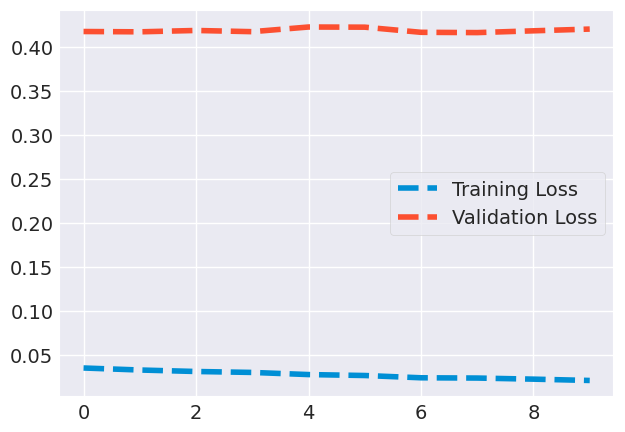

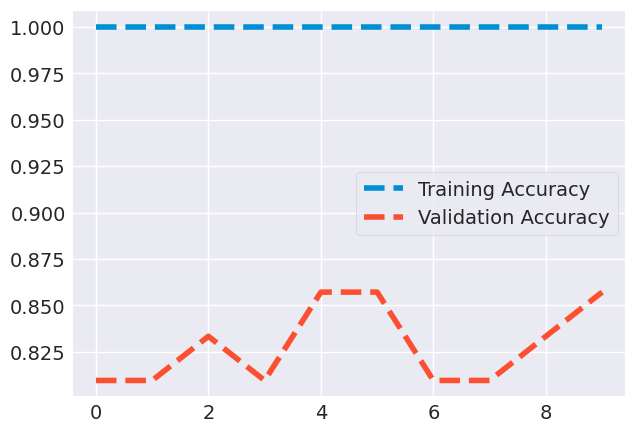

In [43]:
import matplotlib.pyplot as plt

history = model.fit(X_train_padded, y_train, epochs=10, validation_data=(X_test_padded, y_test))

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


In [44]:
from sklearn.metrics import accuracy_score, classification_report

# Melakukan prediksi pada data uji
predictions = model.predict(X_test_padded)

# Menggunakan threshold untuk mengubah nilai probabilitas menjadi label biner (0 atau 1)
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

# Evaluasi model
accuracy = accuracy_score(y_test, predicted_labels)
print(f'Accuracy: {accuracy}')

# Classification Report
print(classification_report(y_test, predicted_labels))


2/2 [==============================] - 0s 6ms/step
Accuracy: 0.8571428571428571
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        24
           1       0.80      0.89      0.84        18

    accuracy                           0.86        42
   macro avg       0.85      0.86      0.86        42
weighted avg       0.86      0.86      0.86        42



In [ ]:
from sklearn.model_selection import cross_val_score

# Contoh penggunaan cross-validation
scores = cross_val_score(model,X_train_padded, y_train, cv=5, scoring='accuracy')
print(f'Cross-Validation Scores: {scores}')
print(f'Mean Accuracy: {scores.mean()}')


TypeError: ignored

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import load_model

In [ ]:
# Menyimpan model
model.save('model_violence.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = load_model('model_violence.h5')

In [ ]:
# Fungsi untuk memprediksi label dan probabilitas dari teks
def predict_label_and_prob(text, model, vectorizer):
    # Preprocessing dan stemming teks
    processed_text = preprocess_and_stem(text)

    # Vectorization menggunakan CountVectorizer
    text_vectorized = vectorizer.transform([processed_text])

    # Melakukan prediksi probabilitas menggunakan model
    prediction_prob = model.predict(text_vectorized.toarray())

    # Mengekstrak label dengan probabilitas tertinggi
    predicted_label = np.argmax(prediction_prob)

    return predicted_label, prediction_prob[0][predicted_label]

In [ ]:
path_model = 'path_model_violence'
model = tf.keras.models.load_model(path_model)

OSError: ignored

In [ ]:
# Gantilah path_vectorizer dengan path tempat menyimpan objek CountVectorizer
path_vectorizer = 'path_vectorizer'
with open(path_vectorizer, 'rb') as f:
    vectorizer = pickle.load(f)

FileNotFoundError: ignored

In [48]:
# Prediksi menggunakan model
y_pred = model.predict(X_test_padded)

2/2 [==============================] - 0s 6ms/step


In [47]:
# Konversi probabilitas menjadi label
y_pred_labels = [1 if pred > 0.5 else 0 for pred in y_pred]

In [46]:
# Evaluasi model
accuracy = accuracy_score(y_test, y_pred_labels)
conf_matrix = confusion_matrix(y_test, y_pred_labels)
class_report = classification_report(y_test, y_pred_labels)

In [45]:
# Tampilkan hasil evaluasi
print(f'Accuracy: {accuracy}')
print('\nConfusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(class_report)

Accuracy: 0.8571428571428571

Confusion Matrix:
[[20  4]
 [ 4 14]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        24
           1       0.78      0.78      0.78        18

    accuracy                           0.81        42
   macro avg       0.81      0.81      0.81        42
weighted avg       0.81      0.81      0.81        42



In [49]:
import joblib

# Fungsi untuk membuat prediksi dan menampilkan hasilnya
def predict_and_display(model, text):
    # Tokenisasi dan stemming pada teks
    text_stemmed = ' '.join([stemmer.stem(word) for word in text.split()])
    text_sequence = tokenizer.texts_to_sequences([text_stemmed])
    text_padded = pad_sequences(text_sequence, maxlen=max_sequence_length, padding='post', truncating='post')

    # Prediksi menggunakan model
    prediction = model.predict(text_padded)[0][0]

    # Menampilkan hasil prediksi
    if prediction > 0.5:
        result = 'Non Vio'
    else:
        result = 'Vio'

    confidence_percentage = round(abs(prediction - 0.5) * 200, 2)

    print(f'Teks: {text}')
    print(f'Prediksi: {result}')
    print(f'Keyakinan: {confidence_percentage}%\n')



# Contoh pengujian
texts_to_test = [
    "Teks ini mengandung kata-kata yang positif dan mendukung.",
    "Saya sangat kecewa dengan produk yang saya beli, kualitasnya sangat buruk.",
    "Film ini benar-benar luar biasa, saya sangat menikmati setiap momennya.",
    "Pelayanan pelanggan sangat ramah dan membantu.",
    "saya melihat orang tua saya sedang memukul adik hingga berdarah dan badanya hingga memar dan menangis",
    "Sangat kecewa dengan produk ini.",
    "Teks positif yang sangat bagus.",
    "saya melihat sebuah kekerasan yang dilakukan suami kepada istri"
]

# Lakukan prediksi untuk setiap teks
for text_to_test in texts_to_test:
    predict_and_display(model, text_to_test)

# Menyimpan model dan tokenizer (vectorizer)
#model.save('text_classification_model.h5')
#joblib.dump(tokenizer, 'tokenizer.joblib')


1/1 [==============================] - 0s 21ms/step
Teks: Teks ini mengandung kata-kata yang positif dan mendukung.
Prediksi: Vio
Keyakinan: 97.45%

1/1 [==============================] - 0s 21ms/step
Teks: Saya sangat kecewa dengan produk yang saya beli, kualitasnya sangat buruk.
Prediksi: Vio
Keyakinan: 83.12%

1/1 [==============================] - 0s 20ms/step
Teks: Film ini benar-benar luar biasa, saya sangat menikmati setiap momennya.
Prediksi: Vio
Keyakinan: 83.12%

1/1 [==============================] - 0s 21ms/step
Teks: Pelayanan pelanggan sangat ramah dan membantu.
Prediksi: Vio
Keyakinan: 35.43%

1/1 [==============================] - 0s 19ms/step
Teks: saya melihat orang tua saya sedang memukul adik hingga berdarah dan badanya hingga memar dan menangis
Prediksi: Vio
Keyakinan: 84.62%

1/1 [==============================] - 0s 21ms/step
Teks: Sangat kecewa dengan produk ini.
Prediksi: Vio
Keyakinan: 35.9%

1/1 [==============================] - 0s 21ms/step
Teks: Teks posit

In [ ]:
def predict_text_sentiment(text, model, tokenizer, max_sequence_length):
    # Tokenisasi dan stemming pada teks input
    stemmed_text = ' '.join([stemmer.stem(word) for word in text.split()])
    text_sequences = tokenizer.texts_to_sequences([stemmed_text])
    text_padded = pad_sequences(text_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

    # Prediksi menggunakan model
    prediction = model.predict(text_padded)[0][0]

    # Konversi probabilitas menjadi label
    predicted_label = 1 if prediction > 0.5 else 0

    # Tampilkan hasil prediksi dan persentase
    if predicted_label > 0.5:
        sentiment = 'Positif'
        confidence = prediction * 100
    else:
        sentiment = 'Negatif'
        confidence = (1 - prediction) * 100

    print(f'Teks: {text}')
    print(f'Prediksi Sentimen: {sentiment}')
    print(f'Kepercayaan: {confidence:.2f}%\n')

# Contoh penggunaan
sample_text_1 = ["Teks positif yang sangat bagus.",
                 "Sangat kecewa dengan produk ini.",
                     "Pelayanan pelanggan sangat ramah dan membantu.",
    "saya melihat orang tua saya sedang memukul adik hingga berdarah dan badanya hingga memar dan menangis",
    "Sangat kecewa dengan produk ini.",
    "Teks positif yang sangat bagus.",
    "saya melihat sebuah kekerasan yang dilakukan suami kepada istri"

]

#predict_text_sentiment(sample_text_1, model, tokenizer, max_sequence_length)
#predict_text_sentiment(sample_text_2, model, tokenizer, max_sequence_length)
# Lakukan prediksi untuk setiap teks
for sample_text_1 in sample_text_1:
    predict_text_sentiment(model, tokenizer, max_sequence_length)

TypeError: ignored

In [1]:
# Fungsi untuk melakukan prediksi pada teks baru
def predict_text(text, model, tokenizer, max_sequence_length):
    # Tokenisasi dan stemming pada teks baru
    text_stemmed = ' '.join([stemmer.stem(word) for word in text.split()])
    text_sequence = tokenizer.texts_to_sequences([text_stemmed])
    text_padded = pad_sequences(text_sequence, maxlen=max_sequence_length, padding='post', truncating='post')

    # Prediksi menggunakan model
    prediction = model.predict(text_padded)[0]

    # Konversi probabilitas menjadi label
    predicted_label = 1 if prediction > 0.5 else 0

    # Persentase prediksi
    confidence_percentage = prediction * 100 if predicted_label == 1 else (1 - prediction) * 100

    return predicted_label, confidence_percentage

# Contoh penggunaan fungsi untuk memprediksi teks baru
new_text = "saya melihat orang tua saya sedang memukul adik hingga berdarah dan badanya hingga memar dan menangis"
predicted_label, confidence_percentage = predict_text(new_text, model, tokenizer, max_sequence_length)

# Tampilkan hasil prediksi dan persentasenya
print(f'Teks: "{new_text}"')
print(f'Prediksi: {predicted_label} dengan kepercayaan {confidence_percentage:.2f}%/n')


NameError: ignored

### CAPE NGEPREDIK ANJER

### EMANG BOLEHHH

In [50]:
model.save('Model_Violence.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
